In [33]:
# nuclio: ignore
import nuclio

In [34]:
%nuclio config kind = "job"
%nuclio config spec.image = "yjbds/ml-models:0.4.7"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'yjbds/ml-models:0.4.7'


In [35]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [36]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from cloudpickle import load
from mlutils import eval_class_model
from urllib.request import urlopen

def xgb_test(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    plots_dest: str = "plots",
    model_evaluator = None,
    default_model: str = "model.pkl"
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     model artifact to be tested
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param plots_dest:      dir for test plots
    :param model_evaluator: WIP: specific method to generate eval, passed in as string
                            or available in this folder
    :param default_model:   'model.pkl', default model artifact file name
    """  
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path.url, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except ValueError as va: 
        model_obj = load(urlopen(os.path.join(str(models_path), default_model)))
    except Exception as a:
        raise Exception("model location likely specified")

    if not model_evaluator:
        # binary and multiclass
        eval_metrics = eval_class_model(context, xtest, ytest, model_obj)

    # just do this inside log_model?
    model_plots = eval_metrics.pop("plots")
    model_tables = eval_metrics.pop("tables")
    for plot in model_plots:
        context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")
    for tbl in model_tables:
        context.log_artifact(tbl, local_path=f"{plots_dest}/{plot.key}.csv")

    context.log_results(eval_metrics)

In [37]:
# nuclio: end-code

### mlconfig

In [38]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [39]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("xgb_test")

# add metadata (for templates and reuse)
fn.spec.default_handler = "xgb_test"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["ml", "test"]
fn.metadata.labels = {"author": "yjb", "framework": "xgboost"}
fn.export("function.yaml")

[mlrun] 2020-05-19 20:58:35,539 function spec saved to path: function.yaml


## tests

In [40]:
if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc('nfsvol', 'nfsvol', '/home/jovyan/data'))

In [41]:
task_params = {
    "name" : "tasks xgb test",
    "params": {
        "label_column"  : "labels",
        "plots_dest"    : "plots/xgb_test"}}

In [42]:
TEST_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master"
DATA_PATH  = "data/classifier-data.csv"
MODELS_PATH = "models/xgb_test"

### run locally

[mlrun] 2020-05-19 20:58:38,180 starting run tasks xgb test uid=d24456f72b6a40639a8b04eb691eb5f2  -> http://mlrun-api:8080
[mlrun] 2020-05-19 20:58:39,700 log artifact calibration curve at /home/jovyan/data/plots/calibration curve.html, size: 27868, db: Y
[mlrun] 2020-05-19 20:58:39,775 log artifact learning curve - auc at /home/jovyan/data/plots/learning curve - auc.html, size: 16735, db: Y
[mlrun] 2020-05-19 20:58:39,839 log artifact learning curve - erreur at /home/jovyan/data/plots/learning curve - erreur.html, size: 14750, db: Y
[mlrun] 2020-05-19 20:58:40,044 log artifact feature-importances at /home/jovyan/data/plots/xgb_test/feature-importances.html, size: 14670, db: Y
[mlrun] 2020-05-19 20:58:40,110 log artifact confusion-matrix-normalized at /home/jovyan/data/plots/xgb_test/confusion-matrix-normalized.html, size: 10530, db: Y
[mlrun] 2020-05-19 20:58:40,169 log artifact roc-binary at /home/jovyan/data/plots/xgb_test/roc-binary.html, size: 17309, db: Y
[mlrun] 2020-05-19 20:58

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...1eb5f2,0,May 19 20:58:38,completed,tasks xgb test,kind=handlerowner=jovyanhost=jupyter-notebook-7588fddc47-ffg72,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,test-accuracy=0.964test-error=0.036rocauc=0.9845582259375362brier_score=0.026451627408418558f1-score=0.9552238805970149precision_score=0.964824120603015recall_score=0.9458128078817734,calibration curvelearning curve - auclearning curve - erreurfeature-importancesconfusion-matrix-normalizedroc-binaryprecision-recall-binaryfeature-importances-tbl


to track results use .show() or .logs() or in CLI: 
!mlrun get run d24456f72b6a40639a8b04eb691eb5f2 --project default , !mlrun logs d24456f72b6a40639a8b04eb691eb5f2 --project default
[mlrun] 2020-05-19 20:58:40,249 run executed, status=completed


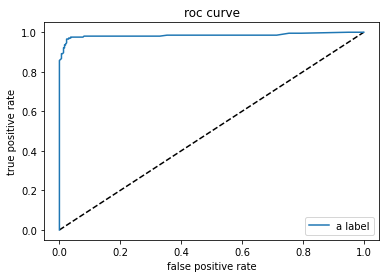

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

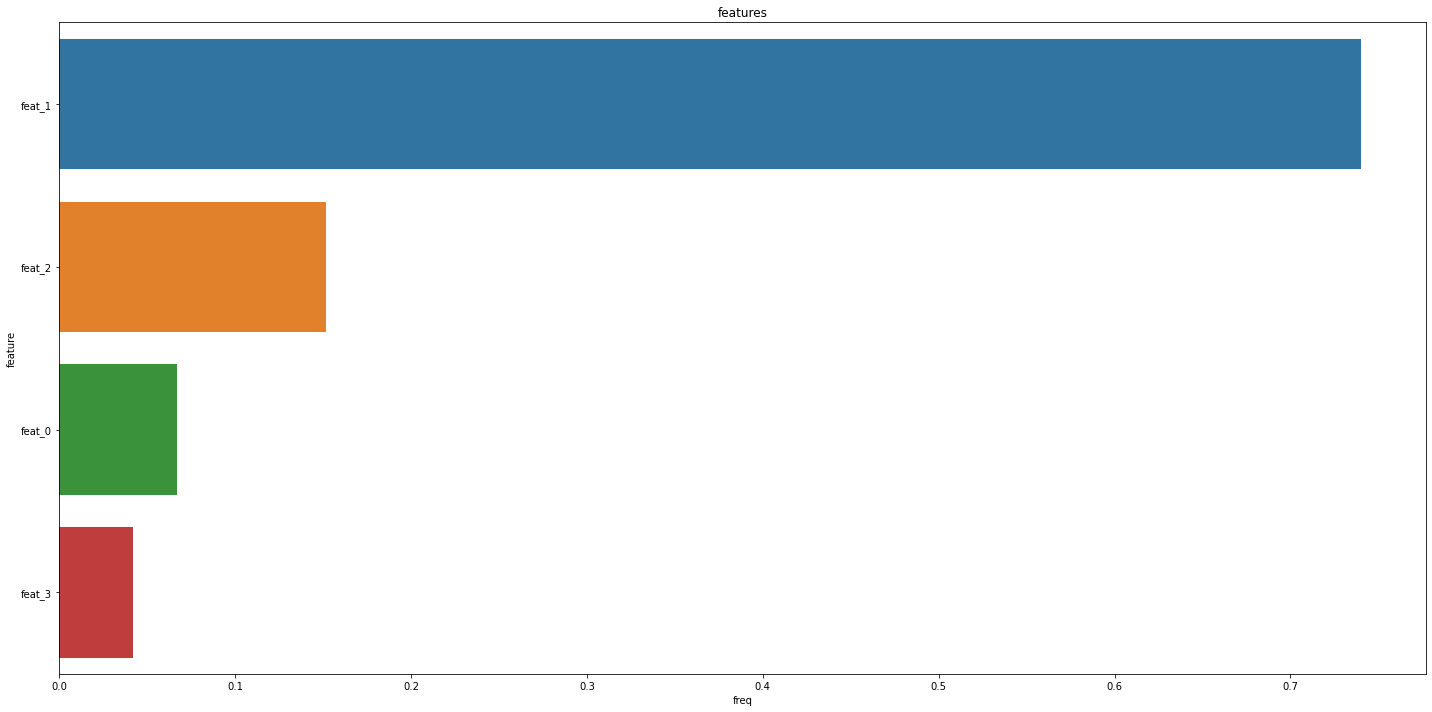

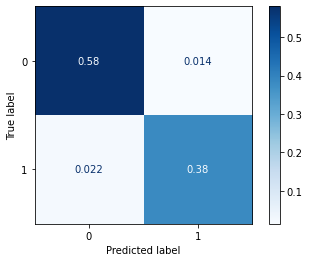

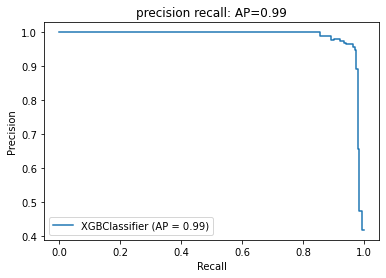

In [43]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=xgb_test,
                inputs={"test_set"      : f"{TEST_REPO}/{DATA_PATH}",
                        "models_path"   : f"{TEST_REPO}/{MODELS_PATH}"},
                workdir=mlconf.artifact_path)

In [44]:
fn.deploy(skip_deployed=True, with_mlrun=False)

run = fn.run(
    NewTask(**task_params),
    inputs={"test_set"      : f"{TEST_REPO}/{DATA_PATH}",
            "models_path"   : f"{TEST_REPO}/{MODELS_PATH}"
        },
    workdir=mlconf.artifact_path)

[mlrun] 2020-05-19 20:58:40,583 starting run tasks xgb test uid=59dabc9b898a4c73aa511437ed673527  -> http://mlrun-api:8080
[mlrun] 2020-05-19 20:58:40,692 Job is running in the background, pod: tasks-xgb-test-7rml4
[mlrun] 2020-05-19 20:58:45,443 log artifact calibration curve at /home/jovyan/data/plots/calibration curve.html, size: 53776, db: Y
[mlrun] 2020-05-19 20:58:45,529 log artifact learning curve - auc at /home/jovyan/data/plots/learning curve - auc.html, size: 33695, db: Y
[mlrun] 2020-05-19 20:58:45,602 log artifact learning curve - erreur at /home/jovyan/data/plots/learning curve - erreur.html, size: 30642, db: Y
[mlrun] 2020-05-19 20:58:45,839 log artifact feature-importances at /home/jovyan/data/plots/xgb_test/feature-importances.html, size: 28218, db: Y
[mlrun] 2020-05-19 20:58:45,887 log artifact confusion-matrix-normalized at /home/jovyan/data/plots/xgb_test/confusion-matrix-normalized.html, size: 19626, db: Y
[mlrun] 2020-05-19 20:58:45,933 log artifact roc-binary at /

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...673527,0,May 19 20:58:43,completed,tasks xgb test,host=tasks-xgb-test-7rml4kind=jobowner=jovyan,models_pathtest_set,label_column=labelsplots_dest=plots/xgb_test,brier_score=0.026451627408418558f1-score=0.9552238805970149precision_score=0.964824120603015recall_score=0.9458128078817734rocauc=0.9845582259375362test-accuracy=0.964test-error=0.036,calibration curvelearning curve - auclearning curve - erreurfeature-importancesconfusion-matrix-normalizedroc-binaryprecision-recall-binaryfeature-importances-tbl


to track results use .show() or .logs() or in CLI: 
!mlrun get run 59dabc9b898a4c73aa511437ed673527  , !mlrun logs 59dabc9b898a4c73aa511437ed673527 
[mlrun] 2020-05-19 20:58:46,841 run executed, status=completed
